<a href="https://colab.research.google.com/github/LalithaMunukutla/Differential-privacy-preserving-in-Deep-Networks/blob/main/DP_Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import torchvision
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
import tensorflow_datasets
import matplotlib.pyplot as plt
import os
from timeit import default_timer
import matplotlib
matplotlib.use('Agg')           # noqa: E402
import matplotlib.gridspec as gridspec


In [ ]:
class DataLoader:
    def __init__(self):
        self.train_data = np.zeros(1)

    def get_mnist(self):
        self.train_data = torchvision.datasets.MNIST(root='../input/mnist/mnist/', train=True, transform=torchvision.transforms.ToTensor(), download=True,)

    def get_train_data(self):
        return self.train_data

In [ ]:
class DataLoader:
    @staticmethod
    def get_train_data(batch_size):
        return torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size, shuffle=True)

    @staticmethod
    def get_test_data(test_batch_size):
        return torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])), batch_size=test_batch_size, shuffle=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2,), nn.ReLU(), nn.MaxPool2d(kernel_size=2),)
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2),)
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [ ]:
def generateNoise(n_in, epsilon, batch_size, test = False):
t    Delta = 0.0;
    if test == True: # do not inject noise in the test phase
        Delta = 0.0;
    else:
        Delta = 10*(n_in + 1/4 * n_in**2); # global sensitivity for the output layer, note that 10 is the number of classes of the output layer
        # Generate the Laplace noise
    perturbFM = np.random.laplace(0.0, Delta/(epsilon*batch_size), n_in)
    perturbFM = np.reshape(perturbFM, [n_in]);
    return perturbFM;

In [ ]:
class LSTM_network:

    def __init__(self, n_hidden, embedding_dim, n_classes, weights=None, debug=False):
        self.n_hidden = n_hidden
        self.embedding_dim = embedding_dim
        self.n_classes = n_classes
        self.debug = debug

        # model parameters
        if weights is not None:
            self.check_weights(weights)
            self.W_x_fward = tf.constant(weights[0], dtype=tf.float64)
            self.W_h_fward = tf.constant(weights[1], dtype=tf.float64)
            self.b_fward = tf.constant(weights[2], dtype=tf.float64)

            self.W_x_bward = tf.constant(weights[3], dtype=tf.float64)
            self.W_h_bward = tf.constant(weights[4], dtype=tf.float64)
            self.b_bward = tf.constant(weights[5], dtype=tf.float64)

            self.W_dense_fw = tf.constant(weights[6][:self.n_hidden], dtype=tf.float64)
            self.W_dense_bw = tf.constant(weights[6][self.n_hidden:], dtype=tf.float64)
            self.b_dense = tf.constant(weights[7], dtype=tf.float64)
        else:
            self.W_x_fward = tf.constant(np.random.randn(self.embedding_dim, 4 * self.n_hidden))
            self.W_h_fward = tf.constant(np.random.randn(self.n_hidden, 4 * self.n_hidden))
            self.b_fward = tf.constant(np.random.randn(4*self.n_hidden,))

            self.W_x_bward = tf.constant(np.random.randn(self.embedding_dim, 4 * self.n_hidden))
            self.W_h_bward = tf.constant(np.random.randn(self.n_hidden, 4 * self.n_hidden))
            self.b_bward = tf.constant(np.random.randn(4 * self.n_hidden, ))

            self.W_dense_fw = tf.constant(np.random.randn(n_hidden, n_classes))
            self.W_dense_bw = tf.constant(np.random.randn(n_hidden, n_classes))
            self.b_dense = tf.constant(np.random.randn(n_classes))

        # prediction of the net
        self.y_hat = tf.Variable(0., shape=tf.TensorShape(None), dtype=tf.float64, name='y_hat')

        # the following order is from keras. You might have to adjust it if you use different frameworks
        self.idx_i = slice(0, self.n_hidden)
        self.idx_f = slice(self.n_hidden, 2 * self.n_hidden)
        self.idx_c = slice(2 * self.n_hidden, 3 * self.n_hidden)
        self.idx_o = slice(3 * self.n_hidden, 4 * self.n_hidden)

    def check_weights(self, weights):
        assert len(weights) == 8
        assert weights[0].shape == weights[3].shape == (self.embedding_dim, 4 * self.n_hidden)
        assert weights[1].shape == weights[4].shape == (self.n_hidden, 4 * self.n_hidden)
        assert weights[2].shape == weights[5].shape == (4 * self.n_hidden, )
        assert weights[6].shape == (2 * self.n_hidden, self.n_classes)
        assert weights[7].shape == (self.n_classes,)

    # x is batch of embedding vectors (batch_size, embedding_dim)
    @tf.function
    def cell_step(self, x, h_old, c_old, W_x, W_h, b):
        # fward pass
        gate_x = tf.matmul(x, W_x)
        gate_h = tf.matmul(h_old, W_h)
        gate_pre = gate_x + gate_h + b
        gate_post = tf.concat([tf.sigmoid(gate_pre[:, self.idx_i]), tf.sigmoid(gate_pre[:, self.idx_f]), tf.tanh(gate_pre[:, self.idx_c]), tf.sigmoid(gate_pre[:, self.idx_o]),], axis=1)
        c_new = gate_post[:, self.idx_f] * c_old + gate_post[:, self.idx_i] * gate_post[:, self.idx_c]
        h_new = gate_post[:, self.idx_o] * tf.tanh(c_new)
        return gate_pre, gate_post, c_new, h_new

    # x is batch of embedding vectors (batch_size, embedding_dim)
    @tf.function
    def one_step_fward(self, x, h_old_fw, c_old_fw):
        fward = self.cell_step(x, h_old_fw, c_old_fw, self.W_x_fward, self.W_h_fward, self.b_fward)
        return fward

    # x_rev is batch of embedding vectors (batch_size, embedding_dim)
    @tf.function
    def one_step_bward(self, x_rev, h_old_bw, c_old_bw):
        bward = self.cell_step(x_rev, h_old_bw, c_old_bw, self.W_x_bward, self.W_h_bward, self.b_bward)
        return bward

    # input is full batch (batch_size, T, embedding_dim)
    @tf.function(experimental_relax_shapes=True)
    def full_pass(self, x):
        assert len(x.shape) == 3, '3 dimensional input required, got input of len {}'.format(len(x.shape))
        batch_size = x.shape[0]
        # we have to reorder the input since tf.scan scans the input along the first axis
        elems = tf.transpose(x, perm=[1,0,2])
        initializer = (tf.constant(np.zeros((batch_size, 4 * self.n_hidden))),  # gates_pre
                       tf.constant(np.zeros((batch_size, 4 * self.n_hidden))),  # gates_post
                       tf.constant(np.zeros((batch_size, self.n_hidden))),      # c_t
                       tf.constant(np.zeros((batch_size, self.n_hidden))))      # h_t
        fn_fward = lambda a, x: self.one_step_fward(x, a[3], a[2])
        fn_bward = lambda a, x: self.one_step_bward(x, a[3], a[2])
        # outputs contain tesnors with (T, gates_pre, gates_post, c,h)
        o_fward = tf.scan(fn_fward, elems, initializer=initializer)
        o_bward = tf.scan(fn_bward, elems, initializer=initializer, reverse=True)
        # final prediction scores
        y_fward = tf.matmul(o_fward[3][-1], self.W_dense_fw)
        y_bward = tf.matmul(o_bward[3][0], self.W_dense_bw)
        y_hat = y_fward + y_bward + self.b_dense
        self.y_hat.assign(y_hat)
        return y_hat, o_fward, o_bward

    def lrp_linear_layer(self, h_in, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0):
        """
        LRP for a linear layer with input dim D and output dim M.
        Args:
        - hin:            forward pass input, of shape (batch_size, D)
        - w:              connection weights, of shape (D, M)
        - b:              biases, of shape (M,)
        - hout:           forward pass output, of shape (batch_size, M) (unequal to np.dot(w.T,hin)+b if more than
                          one incoming layer!)
        - Rout:           relevance at layer output, of shape (batch_size, M)
        - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution
                          is redistributed for sanity check)
        - eps:            stabilizer (small positive number)
        - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore
                          bias/stabilizer redistribution (recommended)
        Returns:
        - Rin:            relevance at layer input, of shape (batch_size, D)
        """
        bias_factor_t = tf.constant(bias_factor, dtype=tf.float64)
        eps_t = tf.constant(eps, dtype=tf.float64)
        sign_out = tf.cast(tf.where(hout >= 0, 1., -1.), tf.float64)   # shape (batch_size, M)
        numerator_1 = tf.expand_dims(h_in, axis=2) * w
        numerator_2 = bias_factor_t * (tf.expand_dims(b, 0) + eps_t * sign_out) / bias_nb_units
        # use the following term if you want to check relevance property
        #numerator_2 =  (bias_factor_t * tf.expand_dims(b, 0) + eps_t * sign_out) / bias_nb_units
        numerator = numerator_1 + tf.expand_dims(numerator_2, 1)
        denom = hout + (eps*sign_out)
        message = numerator / tf.expand_dims(denom, 1) * tf.expand_dims(Rout, 1)
        R_in = tf.reduce_sum(message, axis=2)
        return R_in

    def lrp(self, x, y=None, eps=1e-3, bias_factor=0.0):
        assert len(x.shape) == 3, '3 dimensional input required, got input of len {}'.format(len(x.shape))
        lrp_pass = self.lrp_lstm(x,y,eps, bias_factor)
        # add forward and backward relevances of x.
        # Here we have to reverse R_x_fw since the tf.scan() function starts at the last timestep (T-1) and moves to
        # timestep 0. Therefore the last entry of lrp_pass[2] belongs to the first timestep of x. Likewise, the last
        # entry of lrp_pass[5] (R_x_rev) belongs to the last timestep of x and is thus already in the right order.
        Rx_ = tf.reverse(lrp_pass[2], axis=[0]) + lrp_pass[5]
        Rx = tf.transpose(Rx_, perm=(1,0,2))  # put batch dimension to first dim again
        # remaining relevance is sum of last entry of Rh and Rc
        rest = tf.reduce_sum(lrp_pass[0][-1] + lrp_pass[1][-1] + lrp_pass[3][-1] + lrp_pass[4][-1], axis=1)
        return Rx, rest

    @tf.function
    def lrp_lstm(self, x, y=None, eps=1e-3, bias_factor=0.0):
        batch_size = x.shape[0]
        T = x.shape[1]
        x_rev = tf.reverse(x, axis=[1])
        # update inner states
        y_hat, output_fw, output_bw = self.full_pass(x)
        # if classes are given, use them. Else choose prediction of the network
        if y is not None:
            assert y.shape == (batch_size, )
            if not y.dtype is tf.int64:
                y = tf.cast(y, tf.int64)
            R_out_mask = tf.one_hot(y, depth=self.n_classes, dtype=tf.float64)
        else:
            R_out_mask = tf.one_hot(tf.argmax(y_hat, axis=1), depth=self.n_classes, dtype=tf.float64)
        R_T = y_hat * R_out_mask
        gates_pre_fw, gates_post_fw, c_fw, h_fw = output_fw
        gates_pre_bw, gates_post_bw, c_bw, h_bw = output_bw
        # c and h have one timestep more than x (the initial one, we have to add these zeros manually)
        zero_block = tf.constant(np.zeros((1, batch_size, self.n_hidden)))
        c_fw = tf.concat([c_fw, zero_block], axis=0)
        h_fw = tf.concat([h_fw, zero_block], axis=0)
        gates_pre_bw = tf.reverse(gates_pre_bw, [0])
        gates_post_bw = tf.reverse(gates_post_bw, [0])
        c_bw = tf.reverse(c_bw, [0])
        h_bw = tf.reverse(h_bw, [0])
        c_bw = tf.concat([c_bw, zero_block], axis=0)
        h_bw = tf.concat([h_bw, zero_block], axis=0)

        # first calculate relevaces from final linear layer
        Rh_fw_T = self.lrp_linear_layer(h_fw[T - 1], self.W_dense_fw, self.b_dense, y_hat, R_T, 2*self.n_hidden, eps, bias_factor)
        Rh_bw_T = self.lrp_linear_layer(h_bw[T - 1], self.W_dense_bw, self.b_dense, y_hat, R_T, 2*self.n_hidden, eps, bias_factor)
        #if self.debug:
            #tf.print('Dense: Input relevance', tf.reduce_sum(R_T, axis=1))
            #tf.print('Dense: Output relevance', tf.reduce_sum(Rh_fw_T+Rh_bw_T, axis=1))
        elems = np.arange(T-1, -1, -1)
        initializer = (
                       Rh_fw_T,                                                                     # R_h_fw
                       Rh_fw_T,                                                                     # R_c_fw
                       tf.constant(np.zeros((batch_size, self.embedding_dim)), name='R_x_fw'),      # R_x_fw
                       Rh_bw_T,                                                                     # R_h_bw
                       Rh_bw_T,                                                                     # R_c_bw
                       tf.constant(np.zeros((batch_size, self.embedding_dim)), name='R_x_bw')       # R_x_bw
                       )
        eye = tf.eye(self.n_hidden, dtype=tf.float64)
        zeros_hidden = tf.constant(np.zeros((self.n_hidden)))

        @tf.function
        def update(input_tuple, t):
            # t starts with T-1 ; the values we want to update are essentially Rh, Rc and Rx
            # input_tuple is (R_h_fw_t+1, R_c_fw_t+1, R_x_fw_t+1, R_h_bw_t+1, R_h_bw_t+1, R_x_bw_t+1)
            #forward
            Rc_fw_t = self.lrp_linear_layer(gates_post_fw[t, :, self.idx_f] * c_fw[t-1, :], eye, zeros_hidden, c_fw[t, :],  input_tuple[1], 2*self.n_hidden, eps, bias_factor)
            R_g_fw = self.lrp_linear_layer(gates_post_fw[t,:,self.idx_i] * gates_post_fw[t,:,self.idx_c], eye, zeros_hidden, c_fw[t, :], input_tuple[1], 2*self.n_hidden, eps, bias_factor)
            #if self.debug:
                #tf.print('Fw1: Input relevance', tf.reduce_sum(input_tuple[1], axis=1))
                #tf.print('Fw1: Output relevance', tf.reduce_sum(Rc_fw_t + R_g_fw, axis=1))
            Rx_t = self.lrp_linear_layer(x[:,t], self.W_x_fward[:, self.idx_c], self.b_fward[self.idx_c], gates_pre_fw[t, :, self.idx_c], R_g_fw, self.n_hidden + self.embedding_dim, eps, bias_factor)
            Rh_fw_t = self.lrp_linear_layer(h_fw[t-1, :], self.W_h_fward[:, self.idx_c], self.b_fward[self.idx_c], gates_pre_fw[t, :, self.idx_c], R_g_fw, self.n_hidden + self.embedding_dim, eps, bias_factor)
            #if self.debug:
                #tf.print('Fw2: Input relevance', tf.reduce_sum(R_g_fw, axis=1))
                #tf.print('Fw2: Output relevance', tf.reduce_sum(Rx_t,axis=1)+tf.reduce_sum(Rh_fw_t, axis=1))
            if t != 0:
                Rc_fw_t += Rh_fw_t
            #backward
            Rc_bw_t = self.lrp_linear_layer(gates_post_bw[t, :, self.idx_f] * c_bw[t-1, :], eye, zeros_hidden, c_bw[t, :], input_tuple[4], 2*self.n_hidden, eps, bias_factor)
            R_g_bw = self.lrp_linear_layer(gates_post_bw[t, :, self.idx_i] * gates_post_bw[t, :, self.idx_c], eye, zeros_hidden, c_bw[t,:], input_tuple[4], 2*self.n_hidden, eps, bias_factor)
            #if self.debug:
                #tf.print('Bw1: Input relevance', tf.reduce_sum(input_tuple[4], axis=1))
                #tf.print('Bw1: Output relevance', tf.reduce_sum(Rc_bw_t + R_g_bw, axis=1))
            Rx_rev_t = self.lrp_linear_layer(x_rev[:, t], self.W_x_bward[:, self.idx_c], self.b_bward[self.idx_c], gates_pre_bw[t, :, self.idx_c], R_g_bw, self.n_hidden + self.embedding_dim, eps, bias_factor)
            Rh_bw_t = self.lrp_linear_layer(h_bw[t-1, :], self.W_h_bward[:, self.idx_c], self.b_bward[self.idx_c], gates_pre_bw[t, :, self.idx_c], R_g_bw, self.n_hidden + self.embedding_dim, eps, bias_factor)
            #if self.debug:
                #tf.print('Bw2: Input relevance', tf.reduce_sum(R_g_bw, axis=1))
                #tf.print('Bw2: Output relevance', tf.reduce_sum(Rx_rev_t,axis=1)+tf.reduce_sum(Rh_bw_t, axis=1))
            if t != 0:
                Rc_bw_t += Rh_bw_t
            return Rh_fw_t, Rc_fw_t, Rx_t, Rh_bw_t, Rc_bw_t, Rx_rev_t

        lrp_pass = tf.scan(update, elems, initializer)
        return lrp_pass

In [ ]:
class CnnLstm(nn.Module):
    def __init__(self):
        super(CnnLstm, self).__init__()
        self.cnn = CNN()
        self.rnn=lrp_lstm()
        #self.rnn = nn.LSTM(input_size=1568, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 10)

    def forward(self, x):
        batch_size, time_steps, channels, height, width = x.size()
        #print("x size:")
        #print(x.size())
        c_in = x.view(batch_size * time_steps, channels, height, width)
        #print("c_in size:")
        #print(c_in.size())
        _, c_out = self.cnn(c_in)
        #print("c_out size:")
        #print(c_out.size())
        r_in = c_out.view(batch_size, time_steps, -1)
        #print("r_in size:")
        #print(r_in.size())
        r_out, (_, _) = self.rnn(r_in)
        #print("r_out size:")
        #print(r_out.size())
        r_out2 = self.linear(r_out[:, -1, :])
        #print("r_out2 size:")
        #print(r_out2.size())
        return f.log_softmax(r_out2, dim=1)

Epoch: 1 | train loss: 2.3160
Epoch: 1 | train loss: 2.1378
Epoch: 1 | train loss: 1.7555
Epoch: 1 | train loss: 1.1408
Epoch: 1 | train loss: 1.1242
Epoch: 1 | train loss: 0.8596
Epoch: 1 | train loss: 0.6117
Epoch: 1 | train loss: 0.5239
Epoch: 1 | train loss: 0.5043
Epoch: 1 | train loss: 0.3807
Epoch: 1 | train loss: 0.2640
Epoch: 1 | train loss: 0.2940
<built-in method size of Tensor object at 0x7f59aca375f0>
<built-in method size of Tensor object at 0x7f59ab587d70>
<built-in method size of Tensor object at 0x7f59abc07e90>
<built-in method size of Tensor object at 0x7f59abbf5e90>
<built-in method size of Tensor object at 0x7f59ab55c350>
<built-in method size of Tensor object at 0x7f59abc07290>
<built-in method size of Tensor object at 0x7f59aca378f0>
<built-in method size of Tensor object at 0x7f59ab55c110>
<built-in method size of Tensor object at 0x7f59abbf5ef0>
<built-in method size of Tensor object at 0x7f59ac8b8bf0>

Test set: Average loss: 0.3314, Accuracy: 9317/10000 (93%)


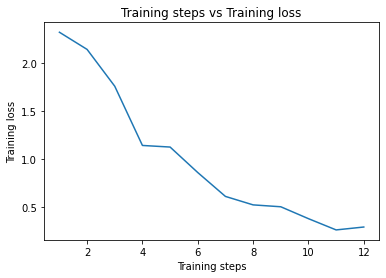

In [ ]:
x_a=[]
y_a=[]
class TrainCNNLSTM:
    def __init__(self):
        self.seed = 1
        self.batch_size = 50
        self.test_batch_size = 1000
        self.epoch = 1
        self.learning_rate = 0.01
        self.step = 100
        self.train_loader = None
        self.test_loader = None
        self.model = CnnLstm()

    def load_data(self):
        data_loader = DataLoader()
        self.train_loader = data_loader.get_train_data(self.batch_size)
        self.test_loader = data_loader.get_test_data(self.test_batch_size)

    def train(self):
        k=1
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        for iteration, (data, target) in enumerate(self.train_loader):
            data = np.expand_dims(data, axis=1)
            data = torch.FloatTensor(data)
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = self.model(data)
            loss = f.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % self.step == 0:
                print('Epoch: {} | train loss: {:.4f}'.format(self.epoch, loss.item()))
                x_a.append(k)
                k=k+1
                y_a.append(loss.item())
        plt.plot(x_a,y_a)
        plt.title("Training steps vs Training loss")
        plt.xlabel("Training steps")
        plt.ylabel("Training loss")
    def test(self):
        test_loss = 0
        correct = 0
        for data, target in self.test_loader:
            data = np.expand_dims(data, axis=1)
            data = torch.FloatTensor(data)
            print(target.size)
            data, target = Variable(data, volatile=True), Variable(target)
            output = self.model(data)
            test_loss += f.nll_loss(output, target, size_average=False).item()  # sum up batch loss
            pred = torch.max(output, 1)[1].data.squeeze()
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

        test_loss /= len(self.test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(self.test_loader.dataset), 100. * correct / len(self.test_loader.dataset)))


train = TrainCNNLSTM()
train.load_data()
train.train()
train.test()

In [ ]:
__all__ = ['cw']


def cw(model, x, y=None, eps=1.0, ord_=2, T=2, optimizer=tf.optimizers.Adam(learning_rate=0.1), alpha=0.9, min_prob=0, clip=(0.0, 1.0)):
    xshape = x.get_shape().as_list()
    noise = tf.get_variable('noise', xshape, tf.float32, initializer=tf.initializers.zeros)
    x_scaled = (x - clip[0]) / (clip[1] - clip[0])
    z = tf.clip_by_value(x_scaled, 1e-8, 1-1e-8)
    xinv = tf.log(z / (1 - z)) / T
    xadv = tf.sigmoid(T * (xinv + noise))
    xadv = xadv * (clip[1] - clip[0]) + clip[0]
    ybar, logits = model(xadv, logits=True)
    ydim = ybar.get_shape().as_list()[1]
    if y is not None:
        y = tf.cond(tf.equal(tf.rank(y), 0), lambda: tf.fill([xshape[0]], y), lambda: tf.identity(y))
    else:
        y = tf.argmin(ybar, axis=1, output_type=tf.int32)
    mask = tf.one_hot(y, ydim, on_value=0.0, off_value=float('inf'))
    yt = tf.reduce_max(logits - mask, axis=1)
    yo = tf.reduce_max(logits, axis=1)
    loss0 = tf.nn.relu(yo - yt + min_prob)
    axis = list(range(1, len(xshape)))
    ord_ = float(ord_)
    if 2 == ord_:
        loss1 = tf.reduce_mean(tf.square(xadv-x))
    else:
        tau0 = tf.fill([xshape[0]] + [1]*len(axis), clip[1])
        tau = tf.get_variable('cw8-noise-upperbound', dtype=tf.float32, initializer=tau0, trainable=False)
        diff = xadv - x - tau
        tau = alpha * tf.to_float(tf.reduce_all(diff < 0, axis=axis))
        loss1 = tf.nn.relu(tf.reduce_sum(diff, axis=axis))
    loss = eps*loss0 + loss1
    train_op = optimizer.minimize(loss, var_list=[noise])
    if 2 != ord_:
        train_op = tf.group(train_op, tau)
    return train_op, xadv, noise

In [ ]:
import tensorflow.compat.v1 as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

img_size = 28
img_chan = 1
n_classes = 10
batch_size = 32

class Timer(object):
    def __init__(self, msg='Starting.....', timer=default_timer, factor=1, fmt="------- elapsed {:.4f}s --------"):
        self.timer = timer
        self.factor = factor
        self.fmt = fmt
        self.end = None
        self.msg = msg

    def __call__(self):
        return self.timer()

    def __enter__(self):
        print(self.msg)
        self.start = self()
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.end = self()
        print(str(self))

    def __repr__(self):
        return self.fmt.format(self.elapsed)

    @property
    def elapsed(self):
        if self.end is None:
            return (self() - self.start) * self.factor
        else:
            return (self.end - self.start) * self.factor

print('\nLoading MNIST')

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255
to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('\nSpliting data')

ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

VALIDATION_SPLIT = 0.1
n = int(X_train.shape[0] * (1-VALIDATION_SPLIT))
X_valid = X_train[n:]
X_train = X_train[:n]
y_valid = y_train[n:]
y_train = y_train[:n]

print('\nConstruction graph')


def model(x, logits=False, training=False):
    with tf.compat.v1.variable_scope('conv0', reuse=tf.AUTO_REUSE):
        z = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3], padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.compat.v1.variable_scope('conv1', reuse=tf.AUTO_REUSE):
        z = tf.layers.conv2d(z, filters=64, kernel_size=[3, 3], padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.compat.v1.variable_scope('flatten', reuse=tf.AUTO_REUSE):
        shape = z.get_shape().as_list()
        z = tf.reshape(z, [-1, np.prod(shape[1:])])

    with tf.compat.v1.variable_scope('mlp', reuse=tf.AUTO_REUSE):
        z = tf.layers.dense(z, units=128, activation=tf.nn.relu)
        z = tf.layers.dropout(z, rate=0.25, training=training)

    logits_ = tf.layers.dense(z, units=10)
    y = tf.nn.softmax(logits_, name='ybar')

    if logits:
        return y, logits_
    return y

class Dummy:
    pass

env = Dummy()

with tf.compat.v1.variable_scope('model', reuse=tf.AUTO_REUSE):
    env.x = tf.compat.v1.placeholder(tf.float32, (None, img_size, img_size, img_chan), name='x')
    env.y = tf.compat.v1.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.compat.v1.placeholder_with_default(False, (), name='mode')
    env.ybar, logits = model(env.x, logits=True, training=env.training)
    with tf.compat.v1.variable_scope('acc', reuse=tf.AUTO_REUSE):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')
    with tf.compat.v1.variable_scope('loss', reuse=tf.AUTO_REUSE):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y, logits=logits)
        env.loss = tf.reduce_mean(xent, name='loss')
    with tf.compat.v1.variable_scope('train_op', reuse=tf.AUTO_REUSE):
        optimizer = tf.train.AdamOptimizer()
        vs = tf.global_variables()
        env.train_op = optimizer.minimize(env.loss, var_list=vs)
    env.saver = tf.train.Saver()
    env.x_fixed = tf.placeholder(tf.float32, (batch_size, img_size, img_size, img_chan), name='x_fixed')
    env.adv_eps = tf.placeholder(tf.float32, (), name='adv_eps')
    env.adv_y = tf.placeholder(tf.int32, (), name='adv_y')
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
    env.adv_train_op, env.xadv, env.noise = cw(model, env.x_fixed, y=env.adv_y, eps=env.adv_eps, optimizer=optimizer)

print('\nInitializing graph')

env.sess = tf.InteractiveSession()
env.sess.run(tf.global_variables_initializer())
env.sess.run(tf.local_variables_initializer())


def evaluate(env, X_data, y_data, batch_size=128):
    print('\nEvaluating')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    loss, acc = 0, 0

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        cnt = end - start
        batch_loss, batch_acc = env.sess.run([env.loss, env.acc], feed_dict={env.x: X_data[start:end], env.y: y_data[start:end]})
        loss += batch_loss * cnt
        acc += batch_acc * cnt
    loss /= n_sample
    acc /= n_sample
    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

def train(env, X_data, y_data, X_valid=None, y_valid=None, epochs=1, load=False, shuffle=True, batch_size=128, name='model'):
    if load:
        if not hasattr(env, 'saver'):
            return print('\nError: cannot find saver op')
        print('\nLoading saved model')
        return env.saver.restore(env.sess, 'model/{}'.format(name))
    print('\nTrain model')
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    for epoch in range(epochs):
        print('\nEpoch {0}/{1}'.format(epoch + 1, epochs))
        if shuffle:
            print('\nShuffling data')
            ind = np.arange(n_sample)
            np.random.shuffle(ind)
            X_data = X_data[ind]
            y_data = y_data[ind]
        for batch in range(n_batch):
            print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
            start = batch * batch_size
            end = min(n_sample, start + batch_size)
            env.sess.run(env.train_op, feed_dict={env.x: X_data[start:end], env.y: y_data[start:end], env.training: True})
        if X_valid is not None:
            evaluate(env, X_valid, y_valid)

    if hasattr(env, 'saver'):
        print('\n Saving model')
        os.makedirs('model', exist_ok=True)
        env.saver.save(env.sess, 'model/{}'.format(name))


def predict(env, X_data, batch_size=128):
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    yval = np.empty((n_sample, n_classes))
    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        y_batch = env.sess.run(env.ybar, feed_dict={env.x: X_data[start:end]})
        yval[start:end] = y_batch
    print()
    return yval


def make_cw(env, X_data, epochs=1, eps=0.1, batch_size=batch_size):
    print('\nMaking adversarials via CW')
    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)
    for batch in range(n_batch):
        with Timer('Batch {0}/{1}   '.format(batch + 1, n_batch)):
            end = min(n_sample, (batch+1) * batch_size)
            start = end - batch_size
            feed_dict = {env.x_fixed: X_data[start:end], env.adv_eps: eps, env.adv_y: np.random.choice(n_classes)}
            env.sess.run(env.noise.initializer)
            for epoch in range(epochs):
                env.sess.run(env.adv_train_op, feed_dict=feed_dict)
            xadv = env.sess.run(env.xadv, feed_dict=feed_dict)
            X_adv[start:end] = xadv
    return X_adv

print('\nTraining')

train(env, X_train, y_train, X_valid, y_valid, load=False, epochs=5, name='mnist')

print('\nEvaluating on clean data')

evaluate(env, X_test, y_test)

print('\nGenerating adversarial data')

n_sample = 128
ind = np.random.choice(X_test.shape[0], size=n_sample, replace=False)
X_test = X_test[ind]
y_test = y_test[ind]
X_adv = make_cw(env, X_test, eps=0.002, epochs=100)

print('\nEvaluating on adversarial data')

evaluate(env, X_adv, y_test)

print('\nRandomly sample adversarial data from each category')

y1 = predict(env, X_test)
y2 = predict(env, X_adv)
z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)
ind = np.logical_and(z0 == z1, z1 != z2)
# print('success: ', np.sum(ind))
ind = z0 == z1
X_test = X_test[ind]
X_adv = X_adv[ind]
z1 = z1[ind]
z2 = z2[ind]
y2 = y2[ind]
ind, = np.where(z1 != z2)
cur = np.random.choice(ind, size=n_classes)
X_org = np.squeeze(X_test[cur])
X_tmp = np.squeeze(X_adv[cur])
y_tmp = y2[cur]
fig = plt.figure(figsize=(n_classes+0.2, 3.2))
gs = gridspec.GridSpec(3, n_classes+1, width_ratios=[1]*n_classes + [0.1], wspace=0.01, hspace=0.01)
label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)

for i in range(n_classes):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_org[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(gs[1, i])
    img = ax.imshow(X_tmp[i]-X_org[i], cmap='RdBu_r', vmin=-1, vmax=1, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(gs[2, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]), fontsize=12)

ax = fig.add_subplot(gs[1, n_classes])
dummy = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1, vmax=1))
dummy.set_array([])
fig.colorbar(mappable=dummy, cax=ax, ticks=[-1, 0, 1], ticklocation='right')

print('\nSaving figure')

gs.tight_layout(fig)
os.makedirs('img', exist_ok=True)
plt.savefig('img/cw2_mnist.png')


Loading MNIST

Spliting data

Construction graph


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/pooling.py:600: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning: `tf.layers.conv2d` is deprecated and will


Initializing graph

Training

Train model

Epoch 1/5

Shuffling data

Evaluating
 loss: 0.0686 acc: 0.9768

Epoch 2/5

Shuffling data

Evaluating
 loss: 0.0453 acc: 0.9863

Epoch 3/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0414 acc: 0.9877

Epoch 4/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0388 acc: 0.9888

Epoch 5/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0346 acc: 0.9908

 Saving model

Evaluating on clean data

Evaluating
 loss: 0.0255 acc: 0.9918

Generating adversarial data

Making adversarials via CW
Batch 1/4   
------- elapsed 3.6551s --------
Batch 2/4   
------- elapsed 3.5734s --------
Batch 3/4   
------- elapsed 3.5278s --------
Batch 4/4   
------- elapsed 3.5394s --------

Evaluating on adversarial data

Evaluating
 loss: 0.1014 acc: 0.9766

Randomly sample adversarial data from each category

Predicting
 batch 1/1

Predicting
 batch 1/1

Saving figure
